In [ ]:
#Using Convolutional Neural Networks for Texts Classification

In [ ]:
#CNN's for Texts In Practice: News Classification

In [ ]:
#Getting the Data

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [2]:
(train_data, val_data), info = tfds.load('ag_news_subset:1.0.0', #version 1.0.0
                                         split=['train[:90%]', 'train[90%:]+test'],
                                         with_info=True, 
                                         as_supervised=True
)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles.
    News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
    ComeToMyHead is an academic news search engine which has been running since July, 2004.
    The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
    information retrieval (ranking, search, etc), xml, data compression, data streaming,
    and any other non-commercial activity.
    For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
    It is used as a text classification benchmark in the following paper:
    Xiang Zhang, Junbo Zhao, Yann LeCun. Char

In [4]:
# Displaying the classes

class_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print(f'The news are grouped into {num_classes} classes that are :{class_names}')

The news are grouped into 4 classes that are :['World', 'Sports', 'Business', 'Sci/Tech']


In [5]:
num_train = info.splits['train'].num_examples
num_val = info.splits['test'].num_examples

print(f'The number of training samples: {num_train} \nThe number of validation samples: {num_val}')

The number of training samples: 120000 
The number of validation samples: 7600


In [6]:
news_df = tfds.as_dataframe(train_data.take(10), info)

news_df.head(10)

,description,label
0,b'AMD #39;s new dual-core Opteron chip is desi...,3
1,b'Reuters - Major League Baseball\\Monday anno...,1
2,b'President Bush #39;s quot;revenue-neutral q...,2
3,b'Britain will run out of leading scientists u...,3
4,"b'London, England (Sports Network) - England m...",1
5,b'TOKYO - Sony Corp. is banking on the \\$3 bi...,0
6,b'Giant pandas may well prefer bamboo to lapto...,3
7,"b'VILNIUS, Lithuania - Lithuania #39;s main pa...",0
8,b'Witnesses in the trial of a US soldier charg...,0
9,"b'Dan Olsen of Ponte Vedra Beach, Fla., shot a...",1


In [7]:
for i in range (0,4):

  print(f"Sample news {i}\n \
  Label: {news_df['label'][i]} {(class_names[i])}\n \
  Description: {news_df['description'][i]}\n----------\n")

Sample news 0
   Label: 3 World
   Description: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
----------

Sample news 1
   Label: 1 Sports
   Description: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
----------

Sample news 2
   Label: 2 Business
   Description: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
----------

Sample news 3
   Label: 3 Sci/Tech
   Description: b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'
----------



In [8]:
#Preparing the Data

In [9]:
buffer_size = 1000
batch_size = 32

train_data = train_data.shuffle(buffer_size)
train_data = train_data.batch(batch_size).prefetch(1)
val_data = val_data.batch(batch_size).prefetch(1)

In [10]:
for news, label in train_data.take(1):

  print(f'Sample news\n----\n {news.numpy()[:4]} \n----\nCorresponding labels: {label.numpy()[:4]}')

Sample news
----
 [b'Some question whether it will be enough to quell the violence and worry about the impact of prolonged tours. Amid a spike in violence in Iraqi cities coinciding with the Fallujah offensive, the US military '
 b'AP - German police have broken up an Internet piracy operation they say had peddled millions of dollars worth of bootleg films, computer games, music and software through a Web site.'
 b"Canadian Press - ST. JOHN'S, Nfld. (CP) - Ottawa and Newfoundland have agreed to disagree over offshore oil royalties."
 b'Business tax cuts and proliferating shelters pushed the effective tax rate of 275 large U.S. corporations down by 20 percent since 2001, study shows.'] 
----
Corresponding labels: [0 3 0 2]


In [11]:
max_features = 10000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features)

In [12]:
text_vectorizer.adapt(train_data.map(lambda description, label : description))

In [13]:
vocab = text_vectorizer.get_vocabulary()
vocab[:10]

['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for']

In [14]:
sample_news = ['This weekend there is a sport match between Man U and Fc Barcelona',
               'Tesla has unveiled its humanoid robot that appeared dancing during the show!']

              

In [15]:
#Creating and Training the Model

In [16]:
input_dim = len(text_vectorizer.get_vocabulary())
input_dim 

10000

In [17]:
model = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0

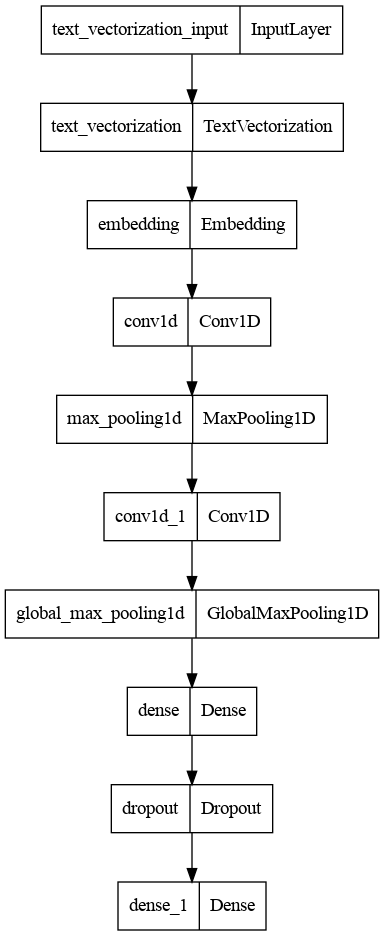

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [20]:
# Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)

In [22]:
# Train the model

history = model.fit(train_data, 
                    epochs=25,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/25
105/105 [==============================] - 6s 34ms/step - loss: 1.3742 - accuracy: 0.2935 - val_loss: 1.2976 - val_accuracy: 0.4243
Epoch 2/25
105/105 [==============================] - 2s 23ms/step - loss: 1.0035 - accuracy: 0.5417 - val_loss: 0.7758 - val_accuracy: 0.7204
Epoch 3/25
105/105 [==============================] - 2s 21ms/step - loss: 0.7042 - accuracy: 0.7402 - val_loss: 0.4968 - val_accuracy: 0.8306
Epoch 4/25
105/105 [==============================] - 3s 28ms/step - loss: 0.5052 - accuracy: 0.8339 - val_loss: 0.4126 - val_accuracy: 0.8618
Epoch 5/25
105/105 [==============================] - 3s 32ms/step - loss: 0.4636 - accuracy: 0.8479 - val_loss: 0.3863 - val_accuracy: 0.8734
Epoch 6/25
105/105 [==============================] - 3s 28ms/step - loss: 0.4358 - accuracy: 0.8580 - val_loss: 0.4007 - val_accuracy: 0.8635
Epoch 7/25
105/105 [==============================] - 3s 29ms/step - loss: 0.4145 - accuracy: 0.8664 - val_loss: 0.3522 - val_accuracy: 0.8914

In [23]:
 #Visualizing the Results

In [24]:
import matplotlib.pyplot as plt

# function to plot accuracy and loss

def plot_acc_loss(history):

  model_history = history.history
  acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']
  loss = model_history['loss']
  val_loss = model_history['val_loss']
  epochs = history.epoch

  plt.figure(figsize=(10,5))
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)

  # Create a new figure with plt.figure()
  plt.figure()

  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)

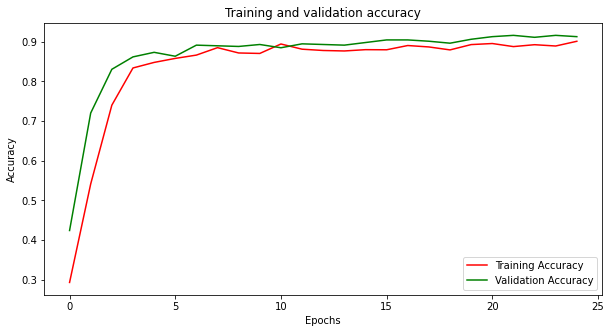

<Figure size 432x288 with 0 Axes>

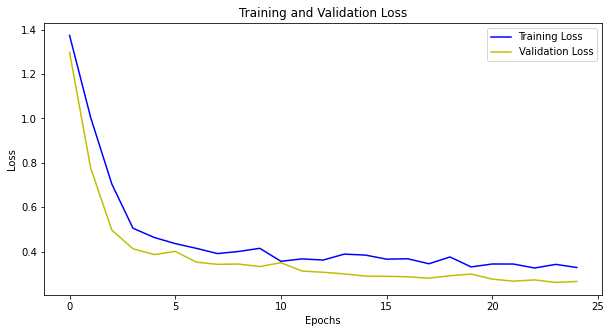

In [25]:
plot_acc_loss(history)

In [ ]:
#Combining CNNs and RNNs for Text Classification

In [ ]:
#Convnets and RNNs Model

In [26]:
conv_rnn_model = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [27]:
conv_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          20544     
                                                                 
 bidirectional (Bidirectiona  (None, 128)             

In [28]:
# Compile the model

conv_rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)


# Train the model

history = conv_rnn_model.fit(train_data, 
                    epochs=25,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/25
105/105 [==============================] - 10s 52ms/step - loss: 1.3027 - accuracy: 0.3310 - val_loss: 0.9875 - val_accuracy: 0.5461
Epoch 2/25
105/105 [==============================] - 4s 42ms/step - loss: 0.9565 - accuracy: 0.5571 - val_loss: 0.6771 - val_accuracy: 0.6760
Epoch 3/25
105/105 [==============================] - 5s 44ms/step - loss: 0.6392 - accuracy: 0.7470 - val_loss: 0.5090 - val_accuracy: 0.8322
Epoch 4/25
105/105 [==============================] - 5s 43ms/step - loss: 0.5023 - accuracy: 0.8301 - val_loss: 0.4344 - val_accuracy: 0.8470
Epoch 5/25
105/105 [==============================] - 4s 41ms/step - loss: 0.4511 - accuracy: 0.8440 - val_loss: 0.4097 - val_accuracy: 0.8618
Epoch 6/25
105/105 [==============================] - 5s 46ms/step - loss: 0.4240 - accuracy: 0.8613 - val_loss: 0.3560 - val_accuracy: 0.8684
Epoch 7/25
105/105 [==============================] - 4s 41ms/step - loss: 0.4173 - accuracy: 0.8637 - val_loss: 0.3769 - val_accuracy: 0.870

In [30]:
#Visualizing the Results

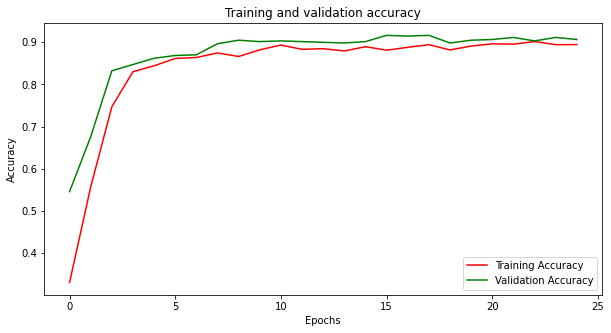

<Figure size 432x288 with 0 Axes>

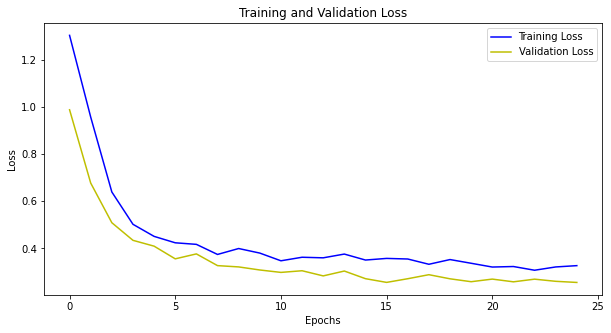

In [31]:
plot_acc_loss(history)

In [32]:
#Performing Inference on New Texts

In [33]:
def predict(model, sample_news, class_names):

  # Convert sample news into array

  sample_news = np.array(sample_news)

  # Predict the news type

  preds = model.predict(sample_news)

  pred_class = np.argmax(preds[0])

  print(f'predicted class: {pred_class} \nPredicted Class name: {class_names[pred_class]}')


In [34]:
sample_news = ['Tesla, a self driving car company is also planning to make a humanoid robot. This humanoid robot appeared dancing in the latest Tesla AI day']

predict(conv_rnn_model, sample_news, class_names)

predicted class: 3 
Predicted Class name: Sci/Tech


In [35]:
sample_news = ["In the last weeks, there has been many transfer suprises in footbal. Ronaldo went back to Old Trafford, "
                "while Messi went to Paris Saint Germain to join his former colleague Neymar."
                "We can't wait to see these two clubs will perform in upcoming leagues"]
            

predict(conv_rnn_model, sample_news, class_names)

predicted class: 1 
Predicted Class name: Sports


In [36]:
sample_news = ["In the latest business news: The tech giant NVIDIA has acquired ARM, a microproccessor company"]
            

predict(conv_rnn_model, sample_news, class_names)

predicted class: 2 
Predicted Class name: Business
